# HW11 Task 1 - Linear model
# KNN, LMNN, SVM, ENN

In [1]:
#install packets
#!pip3 install pylmnn
# !pip install enn

In [46]:
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import time
import timeit

from enn.enn import ENN
from numba.decorators import autojit
from pylmnn import LargeMarginNearestNeighbor as LMNN
from scipy.spatial.distance import euclidean, mahalanobis, minkowski, chebyshev
from sklearn.neighbors import DistanceMetric
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle


%matplotlib inline
# matplotlib.style.use('seaborn')

print (sklearn.__version__)

0.20.2


In [2]:
# path to data
path='winequality-white.csv'
df=pd.read_csv(path, sep=";")
df.head()
# data size
print('\n shape: ',df.shape)

# data info
df.describe()

# target count
type=df['quality'].groupby(df['quality']).count()
print('\n type: ',type)


 shape:  (4898, 12)

 type:  quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64


In [9]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


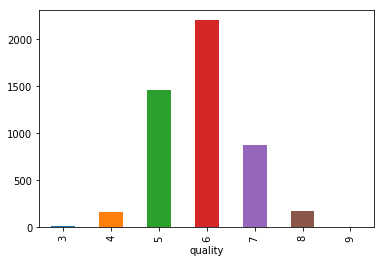

In [11]:
# count target plot
type.plot('bar');

In [12]:
# input data

# get column titles except the last column
features=df.columns[:-1].tolist()

# get data set features
X=df[features].values
# get labels
y=df['quality'].values

# split data to train data set and test data set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)

In [7]:
%%time
# KNN
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

print('\n\n We used kd_tree - sorting alhorytm, manhattan metric, with uniform weights, \
its a compromise on accuracy and speed \n')

print('\n For result KNN alhorytm we used chebyshev metric, that increase score for 0.2 points \n\n')


# store scores of KNN model by K
scores=[]

# loop k from 1 to 8, and get cross validation score of each K value
for k in range(1,31):
    knn=KNeighborsClassifier(k,algorithm='kd_tree',metric='manhattan',weights='uniform')
    score_val=cross_val_score(knn,X_train,y_train,scoring='accuracy',cv=5)
    score_mean=score_val.mean()
    print(f'neibors: {k} score: {score_mean:.3f}')
    scores.append(score_mean)
    
# get index of maxium score along axis, default axis=0 for 1 dimensional array
best_k=np.argmax(scores)+1
print('\nneibor:',best_k)
# generate KNN model
knn=KNeighborsClassifier(best_k,algorithm='kd_tree',metric='chebyshev',weights='uniform')
# fit with train data set
knn.fit(X_train,y_train)
# get Modes presicion rate using test set
print(f'prediction precision rate: {knn.score(X_test,y_test):.5f}')



 We used kd_tree - sorting alhorytm, manhattan metric, with uniform weights, its a compromise on accuracy and speed 


 For result KNN alhorytm we used chebyshev metric, that increase score for 0.2 points 


neibors: 1 score: 0.552
neibors: 2 score: 0.481
neibors: 3 score: 0.453
neibors: 4 score: 0.469
neibors: 5 score: 0.460
neibors: 6 score: 0.472
neibors: 7 score: 0.467
neibors: 8 score: 0.465
neibors: 9 score: 0.458
neibors: 10 score: 0.462
neibors: 11 score: 0.467
neibors: 12 score: 0.461
neibors: 13 score: 0.463
neibors: 14 score: 0.467
neibors: 15 score: 0.469
neibors: 16 score: 0.462
neibors: 17 score: 0.460
neibors: 18 score: 0.461
neibors: 19 score: 0.463
neibors: 20 score: 0.463
neibors: 21 score: 0.468
neibors: 22 score: 0.468
neibors: 23 score: 0.468
neibors: 24 score: 0.467
neibors: 25 score: 0.467
neibors: 26 score: 0.465
neibors: 27 score: 0.465
neibors: 28 score: 0.471
neibors: 29 score: 0.470
neibors: 30 score: 0.467

neibor: 1
prediction precision rate: 0.58204
Wal

In [8]:
%%time
# KNN & LMNN metric

print('\n\n For LMNN metric we used max_iter = 10 and k_test = 1 , that increase score for 0.2-0.3 points \n')
print(' We used only to 5 neibors limit, because dataset is not balanced, later we ll fix that \n')
print(' For result KNN alhorytm we used chebyshev metric, that increase score for 0.5-0.7 points \n\n')

# LMNN metric
#https://pylmnn.readthedocs.io/en/stable/api.html#module-pylmnn.lmnn

scores=[]
# loop k from 1 to 8, and get cross validation score of each K value
k_test, n_components, max_iter = 1, X.shape[1], 10

for k in range(1,5):
    start_time = timeit.default_timer()
    # Instantiate the metric learner
    lmnn = LMNN(n_neighbors=k, max_iter=max_iter, n_components=n_components)
    # Train the metric learner
    lmnn.fit(X_train, y_train)
    # Fit the nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k_test, algorithm='kd_tree', metric='chebyshev', weights='uniform')
    knn.fit(lmnn.transform(X_train), y_train)
    score_val=cross_val_score(knn,lmnn.transform(X_train),y_train,scoring='accuracy',cv=5)
    score_mean=score_val.mean()
    scores.append(score_mean)
    
    end_time = timeit.default_timer() - start_time
    
    print(f'neibors: {k}  ->  score: {score_mean:.5f}  <-  time: {end_time:.0f} s')

# KNN model 

# get index of maxium score along axis, default axis=0 for 1 dimensional array
best_k=np.argmax(scores)+1
print('\nneibor:',best_k)
# Instantiate the metric learner
lmnn = LMNN(n_neighbors=int(best_k), max_iter=max_iter, n_components=n_components)
# Train the metric learner
lmnn.fit(X_train, y_train)
# generate KNN model
knn=KNeighborsClassifier(n_neighbors=best_k)
# fit with train data set
knn.fit(lmnn.transform(X_train), y_train)
# get Modes presicion rate using test set
print(f'prediction precision rate: {knn.score(lmnn.transform(X_test),y_test):.5f}')



 For LMNN metric we used max_iter = 10 and k_test = 1 , that increase score for 0.2-0.3 points 

 We used only to 5 neibors limit, because dataset is not balanced, later we ll fix that 

 For result KNN alhorytm we used chebyshev metric, that increase score for 0.5-0.7 points 


neibors: 1  ->  score: 0.56871  <-  time: 5 s
neibors: 2  ->  score: 0.55921  <-  time: 9 s
neibors: 3  ->  score: 0.55701  <-  time: 14 s
neibors: 4  ->  score: 0.54940  <-  time: 23 s

neibor: 1
prediction precision rate: 0.59347
Wall time: 55.7 s


In [9]:
%%time
# SVC & SVM model
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# https://scikit-learn.org/stable/modules/svm.html#svm-classification

# The implementation is based on libsvm. 
# The fit time complexity is more than quadratic with the number of samples 
# which makes it hard to scale to dataset with more than a couple of 10000 samples.

print('\n\n For SVC alhorytm we used gamma=0.53, that increase score for 0.2 points \n')
print(' accuracy_score precision_score and recall_score have more scores when we used gamma=0.53 \n')
print(' Chanhing kernels by  ‘linear’, ‘poly’, ‘sigmoid’ doesnt icrease score, so we used default rbf \n\n')

clf = SVC(gamma=0.53)
clf.fit(X_train, y_train)
print(f'prediction precision rate: {clf.score(X_test,y_test):.5f} \n')

y_pred = clf.predict(X_test)

print(clf)
print('\nTrain scores: \n')

print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')
#print('roc_auc_score = ', roc_auc_score(y_train, y_pred))



 For SVC alhorytm we used gamma=0.53, that increase score for 0.2 points 

 accuracy_score precision_score and recall_score have more scores when we used gamma=0.53 

 Chanhing kernels by  ‘linear’, ‘poly’, ‘sigmoid’ doesnt icrease score, so we used default rbf 


prediction precision rate: 0.60163 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.53, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Train scores: 

accuracy_score = 0.60163
precision_score = 0.55606
recall_score = 0.32256
f1_score = 0.35384 

Wall time: 7.06 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
%%time
# ENN model
# https://github.com/timo-stoettner/ENN/blob/master/README.md
# article https://mlbootcamp.ru/article/tutorial/

# optimized function for euclidean metric in ENN
def euclidean(x,y):   
    return np.sqrt(np.sum((x-y)**2))

optimized_euclidean = autojit(euclidean)

print('\n\n For ENN alhorytm we used k=2 neihgbors, that increase f1_score for 0.5 points \n')
print(' accuracy_score precision_score and recall_score have more scores when we used k = 2 \n')

clf = ENN(k=2, distance_function = optimized_euclidean)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(' Model ENN: \n',clf)
print('\n Train scores: \n')
print(f' accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f' precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f' recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f' f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')



 For ENN alhorytm we used k=2 neihgbors, that increase f1_score for 0.5 points 

 accuracy_score precision_score and recall_score have more scores when we used k=2 

 Model ENN: 
 ENN(distance_function=CPUDispatcher(<function euclidean at 0x000000000BABA488>),
  k=2)

 Train scores: 

 accuracy_score = 0.48735
 precision_score = 0.27808
 recall_score = 0.32162
 f1_score = 0.28744 

Wall time: 14.5 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [19]:
# Scoring improvement

# Get balanced sample by oversampling
def balanced_koef(serie, element):
    '''evaluation multiply koefficient'''
    return (serie.max() // serie[element])

# balancing algorytm - primitive upsampling 

aray_df = []
for i in type.index:
    
    df_target = df[df['quality'] == i]
    
#     if balanced_koef(type, i) != 0:
#         df_target = pd.concat([df_target] * balanced_koef(type, i))
    df_target = pd.concat([df_target] * balanced_koef(type, i))
    aray_df.append(df_target)

df_balanced = pd.concat(aray_df)

print(f'df: {df.shape}  -->>  balanced df: {df_balanced.shape}')

df: (4898, 12)  -->>  balanced df: (14009, 12)


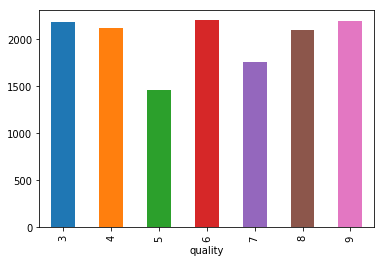

In [20]:
# Count balances type in dataset
type_balanced=df_balanced['quality'].groupby(df_balanced['quality']).count()
type_balanced.plot('bar');
df_balanced = shuffle(df_balanced)

In [49]:
# Balanced dataframe

# df.columns is column labels property
features=df_balanced.columns[:-1].tolist()
X = df_balanced[features].values
y = df_balanced['quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)

# set y to arrays
y_train = y_train.values
y_test = y_test.values

In [52]:
%%time
# KNN && Gridsearch 1-variant
n_neighbors_array = list(range(1,11))
param_grid={'n_neighbors':n_neighbors_array, 'algorithm':['kd_tree','ball_tree'],\
            'metric':['chebyshev','manhattan','minkowski'], 'weights':['uniform','distance']}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid)

grid.fit(X_train, y_train)

print(f'best score: {grid.best_score_:.3f}  nieghbor: {grid.best_estimator_.n_neighbors}')
print(f'prediction precision rate: {grid.score(X_test,y_test):.5f}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best score: 0.851  nieghbor: 1
prediction precision rate: 0.88438
Wall time: 3min 4s


In [53]:
%%time
# KNN 2-variant

# store scores of KNN model by K
scores=[]

# loop k from 1 to 31, and get cross validation score of each K value
for k in range(1,5):
    knn=KNeighborsClassifier(k,algorithm='kd_tree',metric='chebyshev',weights='uniform')
    score_val=cross_val_score(knn,X_train,y_train,scoring='accuracy',cv=10)
    score_mean=score_val.mean()
    print(f'neibors: {k} score: {score_mean:.3f}')
    scores.append(score_mean)  
    
best_k=np.argmax(scores)+1
print('\nneibor:',best_k)
# generate KNN model
knn = KNeighborsClassifier(best_k)
param_grid = {'algorithm' : ['kd_tree'],'metric':['chebyshev','manhattan','minkowski'],\
              'weights':['uniform','distance']}
grid = GridSearchCV(knn, param_grid)

# fit with train data set
grid.fit(X_train,y_train)
# get Modes presicion rate using test set
print(f'prediction precision rate: {grid.score(X_test,y_test):.5f}')

neibors: 1 score: 0.868
neibors: 2 score: 0.817
neibors: 3 score: 0.805
neibors: 4 score: 0.797

neibor: 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


prediction precision rate: 0.88438
Wall time: 4.64 s


In [53]:
%%time
# ENN model
# https://github.com/timo-stoettner/ENN/blob/master/README.md
# article https://mlbootcamp.ru/article/tutorial/

print('\n For ENN alhorytm we used k=1 neihgbors, that return high value of scores \n')

clf = ENN(k=1, distance_function = optimized_euclidean)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(' Model ENN: \n',clf)
print('\n Train scores: \n')
print(f' accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f' precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f' recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f' f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')


 For ENN alhorytm we used k=1 neihgbors, that return high value of scores 

 Model ENN: 
 ENN(distance_function=CPUDispatcher(<function euclidean at 0x000000000BABA488>),
  k=1)

 Train scores: 

 accuracy_score = 0.87953
 precision_score = 0.86237
 recall_score = 0.86772
 f1_score = 0.86440 

Wall time: 1min 38s


In [15]:
# with out grid

# %%time
# # KNN

# # store scores of KNN model by K
# scores=[]

# # loop k from 1 to 8, and get cross validation score of each K value
# for k in range(1,31):
#     knn=KNeighborsClassifier(k,algorithm='kd_tree',metric='manhattan',weights='uniform')
#     score_val=cross_val_score(knn,X_train,y_train,scoring='accuracy',cv=10)
#     score_mean=score_val.mean()
#     print(f'neibors: {k} score: {score_mean:.3f}')
#     scores.append(score_mean)  
    
# best_k=np.argmax(scores)+1
# print('\nneibor:',best_k)
# # generate KNN model
# knn=KNeighborsClassifier(best_k,algorithm='kd_tree',metric='chebyshev',weights='uniform')
# # fit with train data set
# knn.fit(X_train,y_train)
# # get Modes presicion rate using test set
# print(f'prediction precision rate: {knn.score(X_test,y_test):.5f}')

In [ ]:
# # Grid samples

# n_neighbors_array = [1, 2, 3, 4, 5]
# knn = KNeighborsClassifier()
# grid = GridSearchCV(knn, param_grid={'n_neighbors': n_neighbors_array})
# grid.fit(X_train, y_train)

# best_cv_err = 1 - grid.best_score_
# best_n_neighbors = grid.best_estimator_.n_neighbors
# print(best_cv_err, best_n_neighbors)

# clf = GridSearchCV(ENN(), {'k' : [1,5,7,8], "distance_function": [euclidean, mahalanobis]}) 
# clf.fit(X_train, y_train)
# pred_y = clf.predict(X_test)